In [24]:
# Add project root to sys.path so we can import custom modules from anywhere
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.utility import *

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#import score R², mean squared error, and mean absolute error
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [14]:
# Load California Housing dataset
data = fetch_california_housing(as_frame=True)
df = data.frame.copy()
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [15]:
out = DataFramePreprocessor().dataset_overview(X=df, corr_threshold=0.8)
print(out['colinear_pairs'])
out['stats']

[('AveRooms', 'AveBedrms', 0.8476213257130424), ('Latitude', 'Longitude', -0.9246644339150366)]


,variance,unique_values,nan_counts,dtype
MedInc,3.609323e+00,12928,0,float64
HouseAge,1.583963e+02,52,0,float64
AveRooms,6.121533e+00,19392,0,float64
AveBedrms,2.245915e-01,14233,0,float64
Population,1.282470e+06,3888,0,float64
AveOccup,1.078700e+02,18841,0,float64
Latitude,4.562293e+00,862,0,float64
Longitude,4.014139e+00,844,0,float64
MedHouseVal,1.331615e+00,3842,0,float64


In [16]:
X = df.drop(columns=['MedHouseVal', 'AveRooms', 'Latitude'])
y = df['MedHouseVal']

In [28]:
xgb = XGBRegressor(tree_method="hist", random_state=0)
params = {
    "learning_rate": [0.01, 0.1],
    "max_depth":     [3, 6],
    "n_estimators":  [100, 300]
}

# 1) on définit deux métriques
scoring = {
    "R2" : "r2",
    "MAE": "neg_mean_absolute_error"
}

gscv = GridSearchCV(
    estimator = xgb,
    param_grid= params,
    cv        = 4,
    scoring   = scoring,
    refit     = "R2",    # on refit le modèle sur le meilleur R2
    verbose   = 1,
    n_jobs    = 4
)

gscv.fit(X, y)

# résultats “best” sur le R2
print("→ Meilleur R² :", gscv.best_score_)
print("→ Params optimaux pour R² :", gscv.best_params_)

# extraire le MAE correspondant à ce même modèle
best_idx = gscv.best_index_
best_mae = -gscv.cv_results_["mean_test_MAE"][best_idx]
print("→ MAE du même modèle :", best_mae)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
→ Meilleur R² : 0.5994224578774624
→ Params optimaux pour R² : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
→ MAE du même modèle : 0.5171085808436349


In [32]:
import pprint

xgb = XGBRegressor(tree_method="hist", random_state=0)
pprint.pprint(xgb.get_xgb_params())
pipeline = Pipeline([
    #("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("remove_collinear", CollinearityRemover(threshold=10.0)),
    #("dim_reduction", PCA(n_components=3)),
    ("model", xgb)
])

{'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'eval_metric': None,
 'gamma': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'reg:squarederror',
 'random_state': 0,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': None}


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

#1- Score the model, R², mean squared error, and mean absolute error
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"R²: {r2:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}")

XGBoostError: [00:52:41] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\objective.cc:31: Unknown objective function: `{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}`
Objective candidate: rank:ndcg
Objective candidate: rank:pairwise
Objective candidate: rank:map
Objective candidate: survival:aft
Objective candidate: binary:hinge
Objective candidate: multi:softmax
Objective candidate: multi:softprob
Objective candidate: reg:quantileerror
Objective candidate: reg:squarederror
Objective candidate: reg:squaredlogerror
Objective candidate: reg:logistic
Objective candidate: binary:logistic
Objective candidate: binary:logitraw
Objective candidate: reg:gamma
Objective candidate: reg:linear
Objective candidate: reg:pseudohubererror
Objective candidate: count:poisson
Objective candidate: survival:cox
Objective candidate: reg:tweedie
Objective candidate: reg:absoluteerror


Text(0, 0.5, 'Predicted Values')

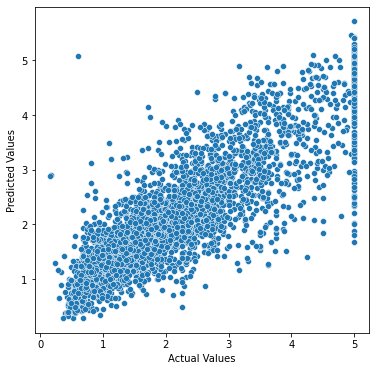

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, ax=ax)
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')